# Doublet identification in scRNA (adult) dataset using _scrublet_ 

In [1]:
import matplotlib.pyplot as plt

from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix

from utils import *

In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.8.1, on 2021-09-23 11:13.


## Create AnnData objects

In [3]:
metadata = pd.read_csv('/nfs/team205/heart/metadata/metadata_scRNA.csv', sep = ',', index_col = 0)

In [4]:
len(metadata.index)

54

In [8]:
adatas = []
for i in range(len(metadata.index)):
    
    sample_id = metadata.index[i]
    path = metadata.loc[metadata.index == sample_id, 'CellBender_out'].to_list()[0]
    filename = sample_id + '_cellbender_out_filtered.h5'

    adatas.append(anndata_from_h5(path + '/' +  filename, analyzed_barcodes_only=False))

In [9]:
n_cells = [adatas[i].n_obs for i in range(len(adatas))]
np.quantile(n_cells, q=[0.0, 0.25, 0.5, 0.75, 1.0])

array([  614.  ,  1569.75,  4798.  , 11211.5 , 15000.  ])

Multiplet rate from [protocol](https://assets.ctfassets.net/an68im79xiti/4tjk4KvXzTWgTs8f3tvUjq/2259891d68c53693e753e1b45e42de2d/CG000183_ChromiumSingleCell3__v3_UG_Rev_C.pdf)

In [5]:
multiplet_rates = pd.read_csv('/nfs/team205/heart/metadata/10x_multiplet_scRNASeq_V3.csv', sep = ',')

In [6]:
multiplet_rates

,N_Cells_Loaded,N_Cells_Recovered,Multiplet_Rate
0,800,500,0.004
1,1600,1000,0.008
2,3200,2000,0.016
3,4800,3000,0.023
4,6400,4000,0.031
5,8000,5000,0.039
6,9600,6000,0.046
7,11200,7000,0.054
8,12800,8000,0.061
9,14400,9000,0.069


In [11]:
metadata['n_cells']=n_cells
metadata['multiplet_rate'] = [multiplet_rates['Multiplet_Rate'][metadata.loc[sample_id,'n_cells'] > multiplet_rates['N_Cells_Recovered']].max() for sample_id in metadata.index]
expected_doublet_rate = np.multiply(metadata['n_cells'], metadata['multiplet_rate']).sum() / metadata['n_cells'].sum()
expected_doublet_rate

0.059679265076651104

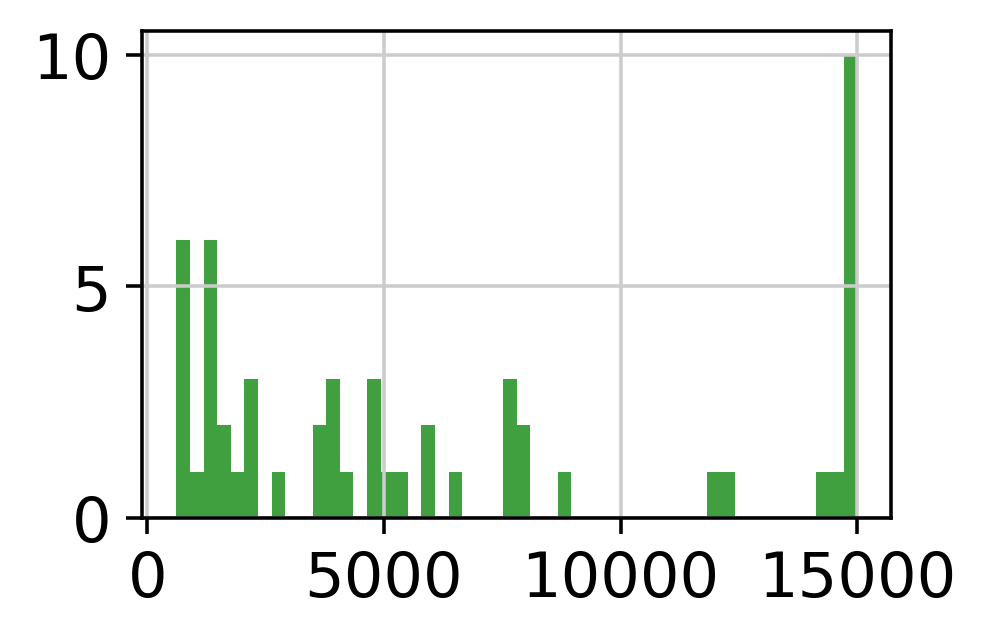

In [14]:
plt.rcParams['figure.figsize'] = [3, 2]
n, bins, patches = plt.hist(n_cells, 50, density=False, facecolor='g', alpha=0.75)

In [15]:
for i in range(len(adatas)):
    adatas[i].var_names_make_unique()
    adatas[i].obs['sample_id'] = metadata.index[i]
    adatas[i].obs.index = metadata.index[i] + '_' + adatas[i].obs.index 
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]

adata = adatas[0].concatenate(adatas[1:], batch_categories = metadata.index)
adata.shape

(345070, 33538)

In [16]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['n_counts'].describe()

count    345070.000000
mean       2072.964844
std        3256.334229
min           0.000000
25%         363.000000
50%        1112.000000
75%        2477.000000
max      113373.000000
Name: n_counts, dtype: float64

## Remove cells with less than 200 genes, remove genes detected in less than 3 cells

In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 125202 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 8033 genes that are detected in less than 3 cells


In [18]:
adata.shape

(219868, 25505)

## Compute QC stats

In [19]:
mito_cells = adata.var_names.str.startswith('MT-')
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_cells].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1)

# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)
# for qc_metric in ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo']:
#     sc.pl.violin(adata, qc_metric, jitter = 0.2)

... storing 'sample_id' as categorical
... storing 'Foetal_or_Adult' as categorical
... storing 'Provider' as categorical
... storing 'Modality' as categorical
... storing 'Mapping_ver' as categorical
... storing 'Reference_genome' as categorical
... storing 'CellBender_out' as categorical
... storing 'feature_type-HCAHeart7656534' as categorical
... storing 'feature_type-HCAHeart7656535' as categorical
... storing 'feature_type-HCAHeart7656536' as categorical
... storing 'feature_type-HCAHeart7656537' as categorical
... storing 'feature_type-HCAHeart7656538' as categorical
... storing 'feature_type-HCAHeart7728604' as categorical
... storing 'feature_type-HCAHeart7728605' as categorical
... storing 'feature_type-HCAHeart7728606' as categorical
... storing 'feature_type-HCAHeart7728607' as categorical
... storing 'feature_type-HCAHeart7728608' as categorical
... storing 'feature_type-HCAHeart7728609' as categorical
... storing 'feature_type-HCAHeart7745966' as categorical
... storing '

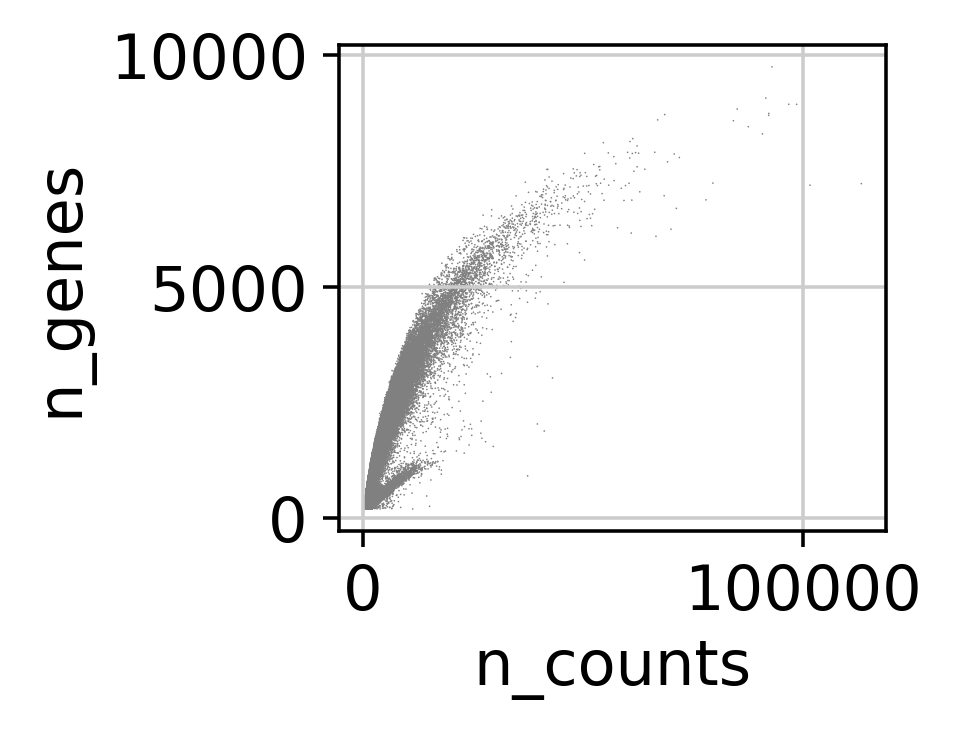

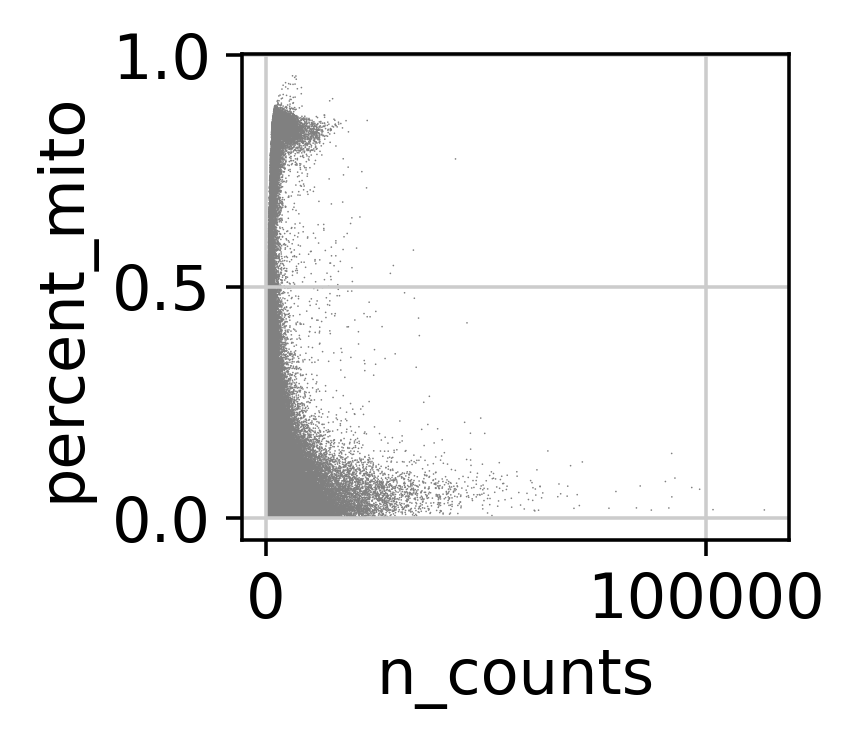

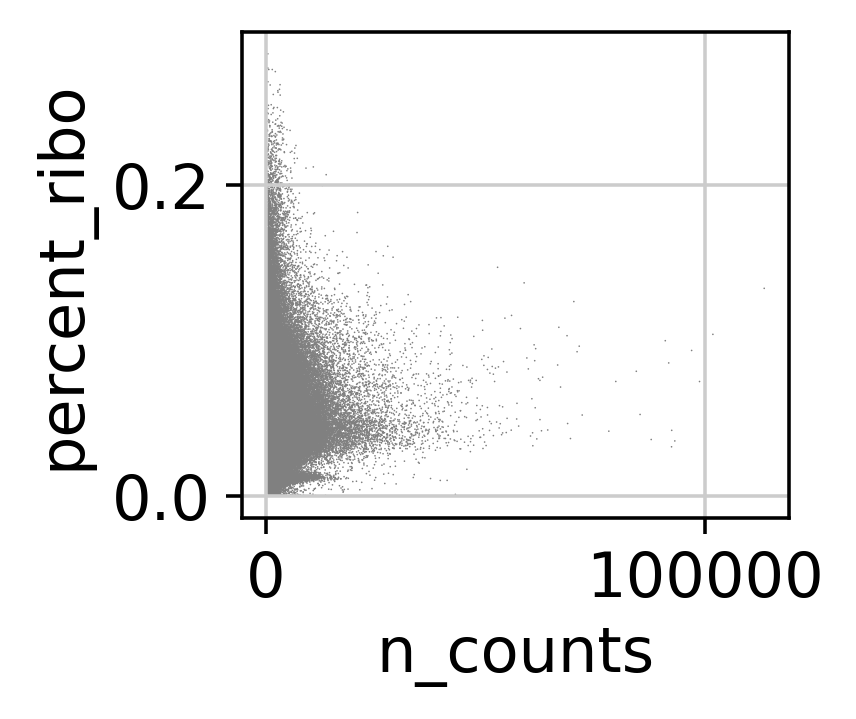

In [20]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')

## Remove cells exceeding the ribo/mito threshold

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


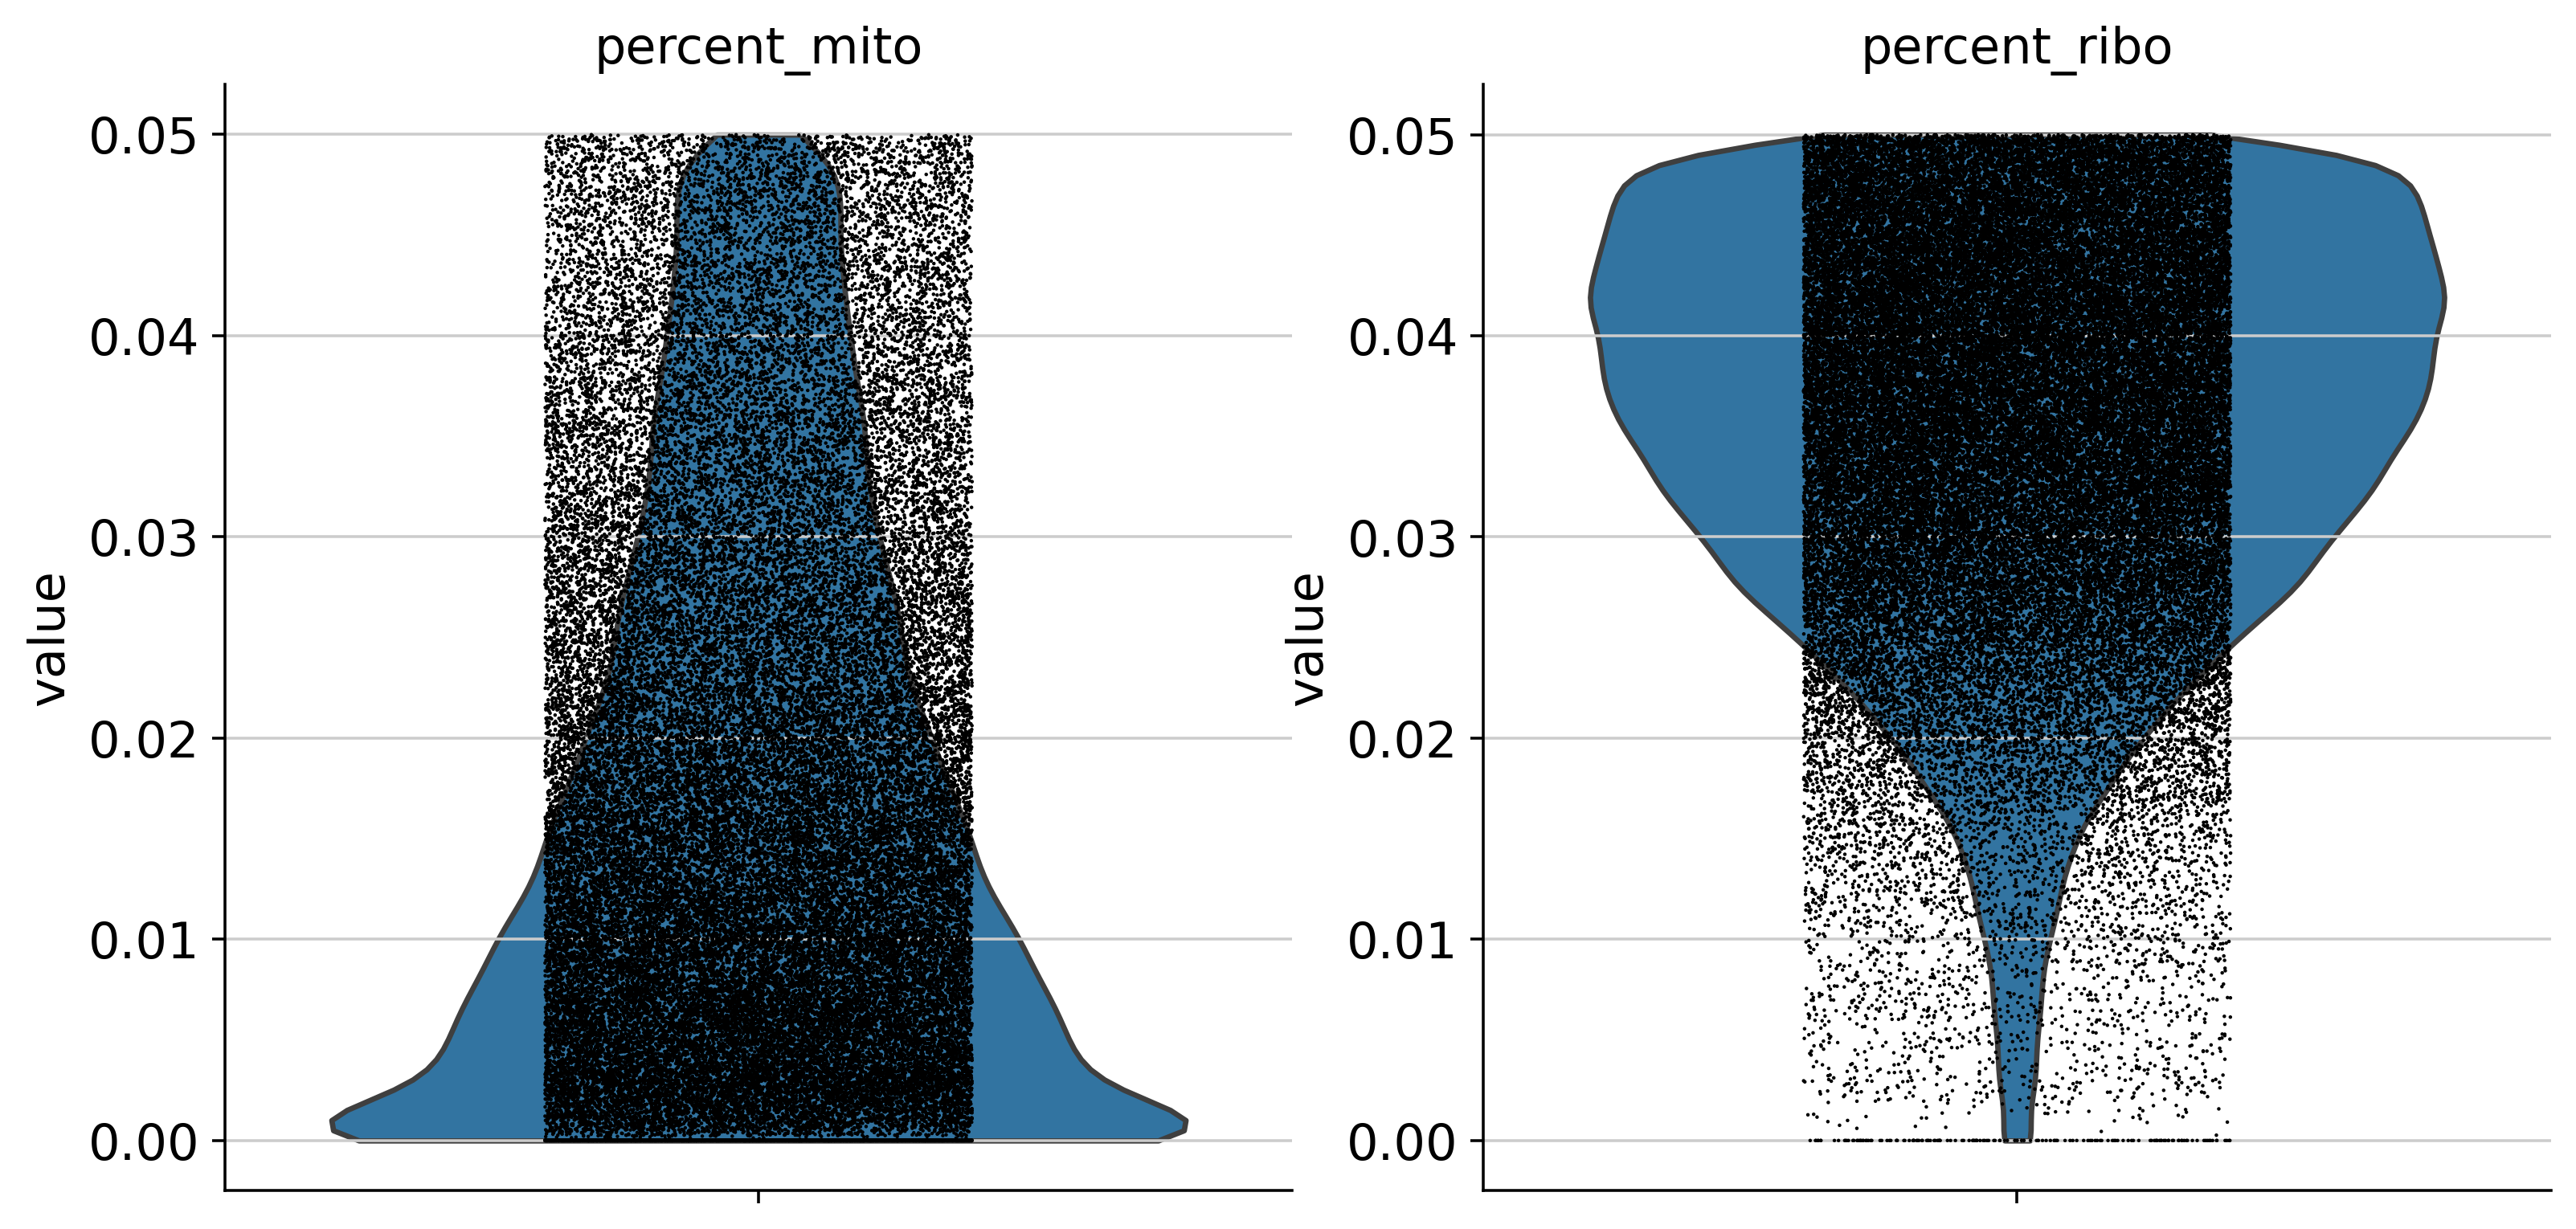

In [21]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata = adata[adata.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True)

In [22]:
adata.shape

(59860, 25505)

In [23]:
adata_backup = adata.copy()

In [24]:
for i in range(len(metadata.index)):
    ad = adata[adata.obs.sample_id == metadata.index[i],:].copy()
    run_scrublet(ad)
    if i==0:
        meta = ad.obs
    else:
        meta = pd.concat([meta, ad.obs])
    del ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_ca

In [26]:
meta_scrub = meta.loc[:,['scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval']].copy()

In [27]:
if meta.index.equals(adata.obs.index):
    adata.obs = pd.concat([adata.obs, meta_scrub], axis=1)
else:
    raise Exception('Different barcodes in meta and adata')

In [28]:
adata.write('/nfs/team205/heart/anndata_objects/scRNA_adult.h5ad')

... storing 'scrublet_leiden' as categorical
